In [4]:
import pandas as pd

# Adjust the path if you uploaded to Colab Files or Drive
df = pd.read_csv('housing.csv')
# Quick look:
print(df.shape)      # rows, columns
display(df.head())   # first few rows
display(df.info())   # types and missing info
display(df.describe())  # basic stats

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


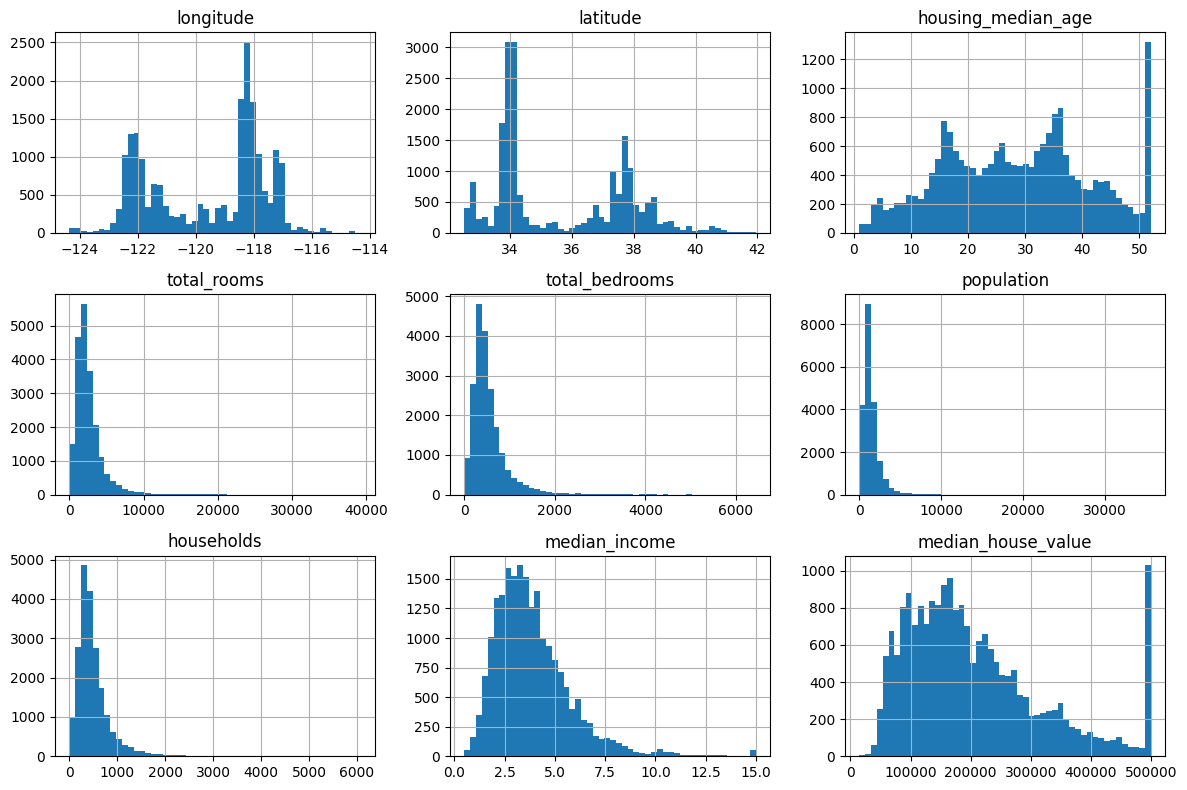

In [5]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(12, 8))
plt.tight_layout()


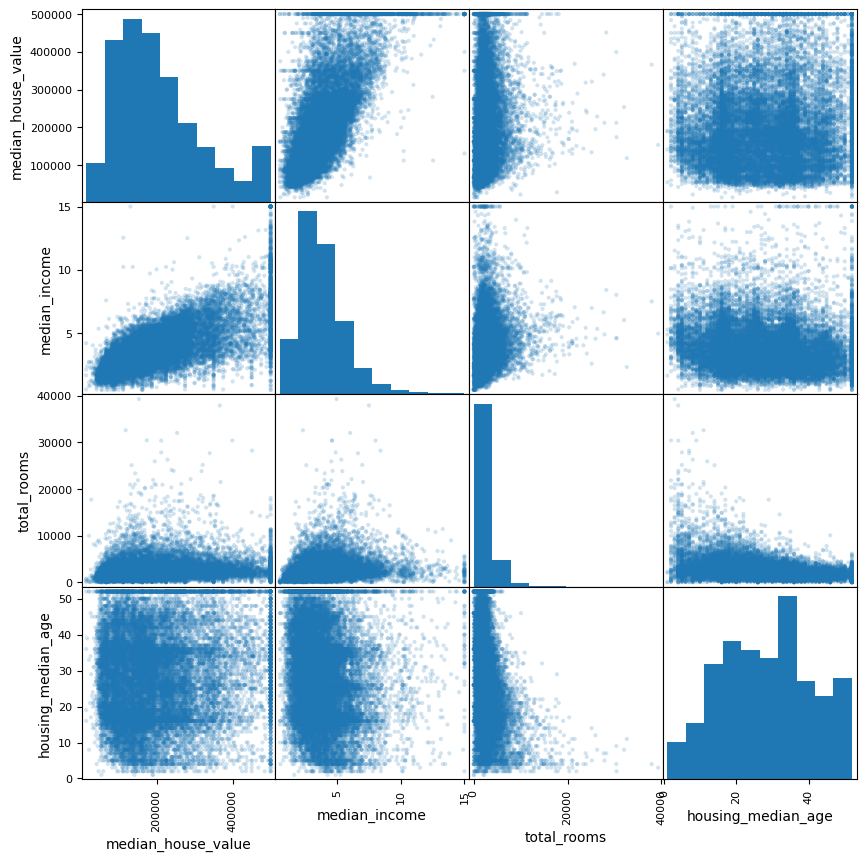

In [6]:
from pandas.plotting import scatter_matrix
cols = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(df[cols], figsize=(10, 10), alpha=0.2)
plt.show()


In [7]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# Create an income category attribute
df['income_cat'] = pd.cut(
    df['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df, df['income_cat']):
    strat_train = df.loc[train_idx].drop('income_cat', axis=1)
    strat_test = df.loc[test_idx].drop('income_cat', axis=1)
# Drop the helper column afterwards


In [8]:
housing = strat_train.copy()
housing_labels = housing['median_house_value'].copy()
housing = housing.drop('median_house_value', axis=1)


In [9]:
from sklearn.impute import SimpleImputer

num_cols = housing.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
housing_num = housing[num_cols]
imputer.fit(housing_num)
housing_num_imputed = pd.DataFrame(imputer.transform(housing_num), columns=num_cols)

# Example: rooms_per_household, bedrooms_per_room, population_per_household
housing_num_imputed['rooms_per_household'] = housing_num_imputed['total_rooms'] / housing_num_imputed['households']
housing_num_imputed['bedrooms_per_room'] = housing_num_imputed['total_bedrooms'] / housing_num_imputed['total_rooms']
housing_num_imputed['population_per_household'] = housing_num_imputed['population'] / housing_num_imputed['households']

housing_cat = housing[['ocean_proximity']].copy()
# One-hot encode:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)  # returns sparse matrix

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
housing_num_prepared = scaler.fit_transform(housing_num_imputed)
# Later combine with categorical:
from scipy import sparse
housing_prepared = sparse.hstack([housing_num_prepared, housing_cat_1hot])



In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(housing_prepared, housing_labels)
    preds = model.predict(housing_prepared)
    mse = mean_squared_error(housing_labels, preds)
    rmse = np.sqrt(mse)
    print(f"{name} training RMSE: {rmse:.2f}")
from sklearn.model_selection import cross_val_score
for name, model in models.items():
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    print(f"{name} CV RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")


LinearRegression training RMSE: 68627.87
DecisionTree training RMSE: 0.00
RandomForest training RMSE: 18656.72
LinearRegression CV RMSE: 69065.59 ± 1272.94
DecisionTree CV RMSE: 70444.52 ± 2062.58
RandomForest CV RMSE: 50661.72 ± 910.73


In [11]:
import pandas as pd

results = {
    "Model": [],
    "CV RMSE Mean": [],
    "CV RMSE Std": []
}

for name, model in models.items():
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    results["Model"].append(name)
    results["CV RMSE Mean"].append(rmse_scores.mean())
    results["CV RMSE Std"].append(rmse_scores.std())

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="CV RMSE Mean"))


              Model  CV RMSE Mean  CV RMSE Std
2      RandomForest  50661.718907   910.729991
0  LinearRegression  69065.590859  1272.944422
1      DecisionTree  70444.522584  2062.580716


In [12]:
# Separate test features and labels
test_features = strat_test.drop('median_house_value', axis=1)
test_labels = strat_test['median_house_value'].copy()

# Separate numerical and categorical parts
test_num = test_features.select_dtypes(include=[np.number])
test_cat = test_features[['ocean_proximity']]

# Impute missing values using trained imputer
test_num_imputed = pd.DataFrame(imputer.transform(test_num), columns=test_num.columns)

# Add combined features
test_num_imputed['rooms_per_household'] = test_num_imputed['total_rooms'] / test_num_imputed['households']
test_num_imputed['bedrooms_per_room'] = test_num_imputed['total_bedrooms'] / test_num_imputed['total_rooms']
test_num_imputed['population_per_household'] = test_num_imputed['population'] / test_num_imputed['households']

# Scale numeric features using trained scaler
test_num_scaled = scaler.transform(test_num_imputed)

# Encode categorical features using trained encoder
test_cat_encoded = cat_encoder.transform(test_cat)

# Combine scaled numerical and encoded categorical features
from scipy import sparse
test_prepared = sparse.hstack([test_num_scaled, test_cat_encoded])

from sklearn.metrics import mean_squared_error

# Use best model (Random Forest)
final_model = models['RandomForest']
final_predictions = final_model.predict(test_prepared)

# Calculate RMSE
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"Final Test RMSE: {final_rmse:.2f}")

import joblib

# Save trained model to file
joblib.dump(final_model, "best_model.pkl")



Final Test RMSE: 48405.47


['best_model.pkl']

In [17]:
## EXERCISE 1:
# 📦 Import necessary libraries
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# 🧪 1. Try SVR with a linear kernel and different values of C
print("🔹 Trying SVR with Linear Kernel...\n")

# Create the SVR model with linear kernel
svr_linear = SVR(kernel='linear')

# Try different values for C (regularization strength)
param_grid_linear = {'C': [0.5, 1, 10, 30, 100]}

# Use GridSearchCV to find the best C
grid_search_linear = GridSearchCV(svr_linear, param_grid_linear,
                                   scoring='neg_mean_squared_error',
                                   cv=3)

# Fit on the training data
grid_search_linear.fit(housing_prepared, housing_labels)

# Compute RMSE from the best score
best_rmse_linear = np.sqrt(-grid_search_linear.best_score_)

# Show results
print("✅ Best RMSE (Linear Kernel):", round(best_rmse_linear, 2))
print("Best Parameters:", grid_search_linear.best_params_)

# 🧪 2. Try SVR with an RBF kernel and different C and gamma
print("\n🔹 Trying SVR with RBF Kernel...\n")

# Create the SVR model with rbf kernel
svr_rbf = SVR(kernel='rbf')

# Try combinations of C and gamma
param_grid_rbf = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1]
}

# Use GridSearchCV for rbf kernel
grid_search_rbf = GridSearchCV(svr_rbf, param_grid_rbf,
                                scoring='neg_mean_squared_error',
                                cv=3)

# Fit on training data
grid_search_rbf.fit(housing_prepared, housing_labels)

# Compute RMSE for the best rbf model
best_rmse_rbf = np.sqrt(-grid_search_rbf.best_score_)

# Show results
print("✅ Best RMSE (RBF Kernel):", round(best_rmse_rbf, 2))
print("Best Parameters:", grid_search_rbf.best_params_)


🔹 Trying SVR with Linear Kernel...

✅ Best RMSE (Linear Kernel): 72134.46
Best Parameters: {'C': 100}

🔹 Trying SVR with RBF Kernel...

✅ Best RMSE (RBF Kernel): 100881.93
Best Parameters: {'C': 100, 'gamma': 0.1}


In [16]:
## EXERCISE 2

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

# SVR with RBF kernel
from sklearn.svm import SVR
svr = SVR(kernel="rbf")

# Define distributions for C and gamma
param_distributions = {
    'C': reciprocal(1, 1000),      # Try values between 1 and 1000 (log scale)
    'gamma': reciprocal(0.001, 0.1)
}

# Randomized search with 10 combinations
rnd_search = RandomizedSearchCV(
    svr, param_distributions,
    n_iter=10, scoring='neg_mean_squared_error',
    cv=3, random_state=42
)

rnd_search.fit(housing_prepared, housing_labels)

# Calculate RMSE from best result
rmse = np.sqrt(-rnd_search.best_score_)
print("Best RMSE (RandomizedSearchCV):", round(rmse, 2))
print("Best Parameters:", rnd_search.best_params_)


Best RMSE (RandomizedSearchCV): 102363.97
Best Parameters: {'C': np.float64(157.0297088405538), 'gamma': np.float64(0.015751320499779727)}


In [21]:
## EXERCISE 3
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = np.argsort(self.feature_importances)[-self.k:]
        return self

    def transform(self, X):
        # Convert sparse to dense array before slicing
        if hasattr(X, "toarray"):
            X = X.toarray()
        return X[:, self.feature_indices_]
# Use previously trained RandomForest for feature importances
feature_importances = final_model.feature_importances_
top_k = 5

selector = TopFeatureSelector(feature_importances, k=top_k)
housing_top_k = selector.fit_transform(housing_prepared)

print("Selected top", top_k, "features.")
print("Original shape:", housing_prepared.shape)
print("Reduced shape :", housing_top_k.shape)


Selected top 5 features.
Original shape: (16512, 16)
Reduced shape : (16512, 5)


In [24]:
## EXERCISE 4:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd

# Reuse the custom TopFeatureSelector
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = np.argsort(self.feature_importances)[-self.k:]
        return self

    def transform(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        return X[:, self.feature_indices_]

# Custom transformer to add combined features
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, 3] / X[:, 5]
        bedrooms_per_room = X[:, 4] / X[:, 3]
        population_per_household = X[:, 2] / X[:, 5]
        return np.c_[X, rooms_per_household, bedrooms_per_room, population_per_household]

# Column names (for reference)
num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('scaler', StandardScaler())
])

# Full preprocessing pipeline
full_preprocess = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

# Fit the preprocessing pipeline to get feature importances
housing_prepared_full = full_preprocess.fit_transform(housing)
forest = RandomForestRegressor(random_state=42)
forest.fit(housing_prepared_full, housing_labels)

# Get feature importances
importances = forest.feature_importances_

# Final full pipeline
full_pipeline = Pipeline([
    ('preprocessing', full_preprocess),
    ('feature_select', TopFeatureSelector(importances, k=5)),
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the full pipeline
full_pipeline.fit(housing, housing_labels)

# Done!
print("Full pipeline built and trained successfully.")


Full pipeline built and trained successfully.


In [25]:
## EXERCISE 5:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'feature_select__k': [3, 5, 7],
    'model__n_estimators': [50, 100],
    'model__max_features': [4, 6, 8]
}

grid_search = GridSearchCV(full_pipeline, param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing, housing_labels)

best_rmse = np.sqrt(-grid_search.best_score_)
print("✅ Best RMSE from GridSearchCV:", round(best_rmse, 2))
print("Best Parameters:", grid_search.best_params_)


✅ Best RMSE from GridSearchCV: 48982.49
Best Parameters: {'feature_select__k': 5, 'model__max_features': 4, 'model__n_estimators': 100}


In [27]:
# REQUIREMENTS.TXT
requirements = """
numpy
pandas
scikit-learn
matplotlib
streamlit
joblib
scipy
"""

# Save to file
with open("requirements.txt", "w") as f:
    f.write(requirements.strip())

# Download the file to your PC
from google.colab import files
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>